### Embedding:
- https://www.guru99.com/word-embedding-word2vec.html
- https://www.kaggle.com/chewzy/tutorial-how-to-train-your-custom-word-embedding
- https://www.kaggle.com/antonsruberts/sentence-embeddings-centorid-method-vs-doc2vec

### Architectures:
- https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings
- https://www.kaggle.com/aialenti/simple-resnet-with-fasttext-embeddings
- https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0
- https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b


- https://github.com/bounabyazid/TextClassification-Keras


- https://colab.research.google.com/drive/16hleozlJZb00nX2Lyq8XKyg9ud0bY98N?usp=sharing#scrollTo=concathidden

### Keras to pytorch:
https://mlwhiz.com/blog/2019/01/06/pytorch_keras_conversion/

In [16]:
import sys

import pickle
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.wrappers import FastText
from gensim.models import KeyedVectors, Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import torch

import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

c:\program files\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


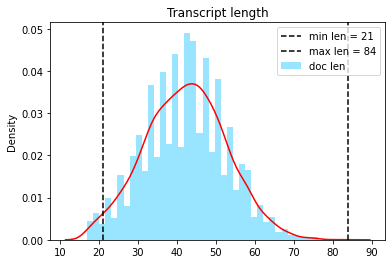

In [3]:
Train_df = pd.read_csv("Dataset/Train.csv")
Val_df = pd.read_csv("Dataset/Validation.csv")
Test_df = pd.read_csv("Dataset/Test.csv")

seq_len = np.array([len(i.split()) for i in Train_df['Transcript'].tolist()])
Train_df['Trans_len'] = Train_df['Transcript'].apply(lambda words: len(words.split(" ")))
Val_df['Trans_len'] = Val_df['Transcript'].apply(lambda words: len(words.split(" ")))
Test_df['Trans_len'] = Test_df['Transcript'].apply(lambda words: len(words.split(" ")))

max_seq_len = np.round(np.mean(seq_len) + np.std(seq_len)*2).astype(int)
min_seq_len = np.round(np.mean(seq_len) - np.std(seq_len)*2).astype(int)

max_seq_len = np.max(seq_len)

sns.distplot(seq_len, hist=True, kde=True, kde_kws={"color": "r"}, color='deepskyblue', label='doc len')
plt.axvline(x=min_seq_len, color='k', linestyle='--', label='min len = '+str(min_seq_len))
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len = '+str(max_seq_len))

plt.title('Transcript length'); plt.legend()
#plt.savefig('Transcript_Length.eps', format='eps', dpi=1000)

plt.show()


Train_df = Train_df[Train_df.Trans_len >= min_seq_len]
Val_df = Val_df[Val_df.Trans_len >= min_seq_len]
Test_df = Test_df[Test_df.Trans_len >= min_seq_len]

train = Train_df['Transcript'].tolist()
val = Val_df['Transcript'].tolist()
test = Test_df['Transcript'].tolist()

path = 'C:/Users/user/Desktop/PretrainedModels/'

In [4]:
def Tokenize(Texts):
    token = text.Tokenizer()
    token.fit_on_texts(Texts)
    word_index = token.word_index
    
    return word_index

In [20]:
#POS
def POS(train, val, test):
    train_pos, val_pos, test_pos = [], [], []
    
    for text in train:
        for word, pos in nltk.pos_tag(nltk.word_tokenize(str(text))):
            train_pos.append(pos)
    for text in train:
        for word, pos in nltk.pos_tag(nltk.word_tokenize(str(text))):
            val_pos.append(pos)    
    for text in test:
        for word, pos in nltk.pos_tag(nltk.word_tokenize(str(text))):
            test_pos.append(pos)
            
    vectorizer = CountVectorizer()
    BOW_train = vectorizer.fit_transform(train_pos)
    BOW_val = vectorizer.transform(val_pos)
    BOW_test = vectorizer.transform(test_pos)
    
    return BOW_train, BOW_val, BOW_test

#BOW word level
def BOW_Word(train, val, test):
    vectorizer = CountVectorizer(max_features=5000)
    BOW_train = vectorizer.fit_transform(train)
    BOW_val = vectorizer.transform(val)
    BOW_test  = vectorizer.transform(test)
    
    return BOW_train, BOW_val, BOW_test

#BOW Ngram level
def BOW_Ngram(train, val, test):
    vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000)
    BOW_train = vectorizer.fit_transform(train)
    BOW_val = vectorizer.transform(val)
    BOW_test  = vectorizer.transform(test)
    
    return BOW_train, BOW_val, BOW_test

# word level tf-idf
def TF_IDF_Word(train, val, test):
    tfidf_vect = TfidfVectorizer(analyzer='word', max_features=5000)
    xtrain_tfidf =  tfidf_vect.fit_transform(train)
    xvalid_tfidf =  tfidf_vect.transform(val)
    xtest_tfidf =  tfidf_vect.transform(test)
    
    return xtrain_tfidf, xvalid_tfidf, xtest_tfidf

# word level ngram level tf-idf
def TF_IDF_Ngram(train, val, test):
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,5), max_features=5000)
    xtrain_tfidf_ngram =  tfidf_vect_ngram.fit_transform(train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(val)
    xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test)
    
    return xtrain_tfidf_ngram, xvalid_tfidf_ngram, xtest_tfidf_ngram

# characters level tf-idf
def TF_IDF_Char_Ngram(train, val, test):
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(3,7), max_features=5000)
    xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.fit_transform(train)
    xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(val)
    xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test)
    
    return xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars, xtest_tfidf_ngram_chars

def Train_Embedding(train, val, test, method=''):
    train_tokens, val_tokens, test_tokens = [], [], []
    
    for text in train:
        train_tokens.append(text.split())
    for text in val:
        val_tokens.append(text.split())
    for text in test:
        test_tokens.append(text.split())

    if method == 'word2vec':
        model= Word2Vec(train_tokens+val_tokens+test_tokens, min_count=1, window=10, size=300, workers=10, iter=1000)
        model.save('Features/OCEAN_W2Vec.bin')
    elif method == 'glove':
        model= Word2Vec(train_tokens+val_tokens+test_tokens, sg=1, min_count=1, window=10, size=300, workers=10, iter=1000)
        model.save('Features/OCEAN_Glove.bin')
    elif method == 'fasttext':
        model = FastText(train_tokens+val_tokens+test_tokens, size=300, workers=10, iter=1000, min_count=1)
        model.save('Features/OCEAN_FastText.bin')
    elif method == 'doc2vec':
        documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tokens+val_tokens+test_tokens)]
        model = Doc2Vec(documents, vector_size=300, window=10, min_count=1, workers=2, dm = 1, epochs=1000)
        model.save('Features/OCEAN_Doc2Vec.bin')
    else:
        print('Wrong model...')
        
def Glove_2_W2Vec(Texts):
    train_tokens = []
    
    for text in Texts:
        train_tokens.append(text.split())
        
    glove_file = datapath(path+'glove.6B.300d.txt')
    tmp_file = get_tmpfile("test_word2vec.txt")
    _ = glove2word2vec(glove_file, tmp_file)
    model = KeyedVectors.load_word2vec_format(tmp_file)
       
    model.build_vocab(train_tokens, update=True)  # Update the vocabulary
    model.train(train_tokens, total_examples=len(train_tokens), epochs=10)
    
    model.save('Features/OCEAN_Pre_Glove.bin')
    print('Done')
    
def FineTune_FastText(Texts):
    train_tokens = []
    
    for text in Texts:
        train_tokens.append(text.split())
        
    #model = FastText.load_fasttext_format(path+'wiki-news-300d-1M.vec')
    model = KeyedVectors.load_word2vec_format(path+'wiki-news-300d-1M.vec')   
    model.build_vocab(train_tokens, update=True)  # Update the vocabulary
    model.train(train_tokens, total_examples=len(train_tokens), epochs=10)
    
    model.save('Features/OCEAN_Pre_FastText.bin')
    print('Done')
    
#W2Vec
def W2Vec(train, val, test):
    train_tokens, val_tokens, test_tokens = [], [], []
    
    for text in train:
        train_tokens.append(text.split())
    for text in val:
        val_tokens.append(text.split())
    for text in test:
        test_tokens.append(text.split())

    model= Word2Vec(train_tokens+val_tokens+test_tokens, min_count=1, window=10, size=300, workers=4, iter=1000)
    model.save('Features/OCEAN_W2Vec.bin')

    word_index = Tokenize(train+val+test)
    Dict = {word:model.wv[word] for word in word_index.keys()}
    
    # create token-embedding mapping
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = Dict[word]
        embedding_matrix[i] = Dict[word]
            
    return embedding_matrix

#BERT
def Bert_Features(Data, max_seq_len, batch_size = 32):
    device = torch.device("cuda")
    
    # import BERT-base pretrained model
    bert = AutoModel.from_pretrained('bert-base-uncased')
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    bert = bert.to(device)

    Tokens_Data = tokenizer.batch_encode_plus(Data, max_length = max_seq_len,
             padding=True, truncation=True,return_token_type_ids=False)

    Data_seq = torch.tensor(Tokens_Data['input_ids']).to(device)
    Data_mask = torch.tensor(Tokens_Data['attention_mask']).to(device)

    train_data = TensorDataset(Data_seq, Data_mask)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler,\
                              batch_size=batch_size)
    Features = []

    for step, batch in enumerate(train_dataloader):   
        batch = [r.to(device) for r in batch]
        sent_id, mask = batch
        _, Feature_Vec = bert(sent_id, mask)

        Feature_Vec = Feature_Vec.detach().cpu().numpy()        
        Features.append(Feature_Vec)
    
    Features  = np.concatenate(Features, axis=0)
    return Features

def Text_embedding(model, Texts):
    Texts_embed = []
    for text in Texts:
        text_embed = []
        for word in text.split():          
            text_embed = np.add(text_embed, model.wv[word])
        text_embed = np.divide(text_embed, len(text.split()))
        Texts_embed.append(text_embed)
    return Texts_embed

In [24]:
#FineTune_FastText(train+val+test)
train_tokens = []
    
for text in train+val+test:
    train_tokens.append(text.split())
        
#model = FastText.load_fasttext_format(path+'wiki-news-300d-1M.vec')
model = KeyedVectors.load_word2vec_format(path+'wiki-news-300d-1M.vec', binary=False)   

In [27]:
#model.build_vocab([list(model.vocab.keys())], update=True)  # Update the vocabulary
model.train(train_tokens, total_examples=len(train_tokens), epochs=5)
    
model.save('Features/OCEAN_Pre_FastText.bin')

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'train'

In [31]:
!pip install fasttext

Defaulting to user installation because normal site-packages is not writeable
  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Running setup.py clean for fasttext
Failed to build fasttext
    Running setup.py install for fasttext: started
    Running setup.py install for fasttext: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\program files\python36\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\user\\AppData\\Local\\Temp\\pip-install-a6bybji7\\fasttext_961774c810844e219da1b96e1d36a0ae\\setup.py'"'"'; __file__='"'"'C:\\Users\\user\\AppData\\Local\\Temp\\pip-install-a6bybji7\\fasttext_961774c810844e219da1b96e1d36a0ae\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\user\AppData\Local\Temp\pip-wheel-ma6d96v9'
       cwd: C:\Users\user\AppData\Local\Temp\pip-install-a6bybji7\fasttext_961774c810844e219da1b96e1d36a0ae\
  Complete output (18 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.6
  creating build\lib.win-amd64-3.6\fasttext
  copying python\fasttext_module\fasttext\FastText.py -> build\lib.

In [6]:
def Retrain_Model(path, Texts):
    train_tokens = []
    
    for text in Texts:
        train_tokens.append(text.split())

    model0 = KeyedVectors.load_word2vec_format(path0+'GoogleNews-vectors-negative300.bin', binary=True)
    model = Word2Vec.load(path)
    total_examples = model.corpus_count
    
    #load words from pretrained google dataset    
    model.build_vocab([list(model0.vocab.keys())], update=True)    
    model.intersect_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True, lockf=1.0)

    #retrain pretrained w2v from new dataset    
    model.train(train_tokens, total_examples=total_examples , epochs = 5)
    
    model.save('Features/OCEAN_Pre_W2Vec.bin')
    print('Done')
    
Retrain_Model('Features/OCEAN_W2Vec.bin', train+val+test)

Done
